In [5]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sports-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1209061%2F5595172%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240329%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240329T071544Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D50b508b9ec5a62847b36cf8f3fed23007e60945e64b7cd793ddcb6285a5809b255feb12e36d2a63d0b044df72bebbe242dbf027a5310203b3f487f7b0f6a993b17c725972fa563902a9166900ad9250e4a0935abb1421b2849e03f86362a3d64b3606177938905579e42ff20fc8c2e53d058b611c4da6a42a89fb1914817dd09f185ddf66107a2c7a6943f94c41307d9dce31f32f26bbbf703ff3db8e6c7057d0705ddefb886234cf64720cc7421e78cf028c3169c9b18f5eff368f69cbacbf473bdd5cefcbc8fbc1f6ea1d1209bce3cf17f3a239d617f857a22151ac67622550495c122bf96d13db8d945427c1699846bf7cf87c57c923eedd06d7095408085'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 444540604 bytes downloaded
Downloaded and uncompressed: sports-classification
Data source import complete.


In [7]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Выходные данные были обрезаны до нескольких последних строк (5000).
/kaggle/input/sports-classification/train/polo/007.jpg
/kaggle/input/sports-classification/train/polo/147.jpg
/kaggle/input/sports-classification/train/polo/011.jpg
/kaggle/input/sports-classification/train/polo/100.jpg
/kaggle/input/sports-classification/train/polo/019.jpg
/kaggle/input/sports-classification/train/polo/134.jpg
/kaggle/input/sports-classification/train/polo/070.jpg
/kaggle/input/sports-classification/train/polo/048.jpg
/kaggle/input/sports-classification/train/polo/152.jpg
/kaggle/input/sports-classification/train/polo/059.jpg
/kaggle/input/sports-classification/train/polo/050.jpg
/kaggle/input/sports-classification/train/polo/104.jpg
/kaggle/input/sports-classification/train/polo/041.jpg
/kaggle/input/sports-classification/train/polo/021.jpg
/kaggle/input/sports-classification/train/polo/144.jpg
/kaggle/input/sports-classification/train/polo/004.jpg
/kaggle/input/sports-classification/train/polo/022.j

In [9]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [14]:
trnsfrms_for_train = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
    ]
)
trnsfrms_for_valid = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
    ]
)

In [72]:
import torchvision
train_dataset = torchvision.datasets.ImageFolder('/kaggle/input/sports-classification/train',
                                                 transform=trnsfrms_for_train)
valid_dataset = torchvision.datasets.ImageFolder('/kaggle/input/sports-classification/valid',
                                                 transform=trnsfrms_for_valid)

In [73]:
valid_dataset

Dataset ImageFolder
    Number of datapoints: 500
    Root location: /kaggle/input/sports-classification/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [71]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 13492
    Root location: /kaggle/input/sports-classification/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [16]:
idx2class = {j: i for i, j in train_dataset.class_to_idx.items()}
idx2class

{0: 'air hockey',
 1: 'ampute football',
 2: 'archery',
 3: 'arm wrestling',
 4: 'axe throwing',
 5: 'balance beam',
 6: 'barell racing',
 7: 'baseball',
 8: 'basketball',
 9: 'baton twirling',
 10: 'bike polo',
 11: 'billiards',
 12: 'bmx',
 13: 'bobsled',
 14: 'bowling',
 15: 'boxing',
 16: 'bull riding',
 17: 'bungee jumping',
 18: 'canoe slamon',
 19: 'cheerleading',
 20: 'chuckwagon racing',
 21: 'cricket',
 22: 'croquet',
 23: 'curling',
 24: 'disc golf',
 25: 'fencing',
 26: 'field hockey',
 27: 'figure skating men',
 28: 'figure skating pairs',
 29: 'figure skating women',
 30: 'fly fishing',
 31: 'football',
 32: 'formula 1 racing',
 33: 'frisbee',
 34: 'gaga',
 35: 'giant slalom',
 36: 'golf',
 37: 'hammer throw',
 38: 'hang gliding',
 39: 'harness racing',
 40: 'high jump',
 41: 'hockey',
 42: 'horse jumping',
 43: 'horse racing',
 44: 'horseshoe pitching',
 45: 'hurdles',
 46: 'hydroplane racing',
 47: 'ice climbing',
 48: 'ice yachting',
 49: 'jai alai',
 50: 'javelin',
 5

In [17]:
train_loader = DataLoader(train_dataset, batch_size=92, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=92, shuffle=True)

In [51]:
from torchvision.models import resnet18, ResNet18_Weights
class MyResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
    #замена слоя
    self.model.fc = nn.Linear(512, 100)
    #разморозка
    for i in self.model.parameters():
      i.requires_grad = False

    self.model.fc.weight.requires_grad = True
    self.model.fc.bias.requires_grad = True

  def forward(self, x):
    return self.model(x)

model = MyResNet()
model.to(DEVICE)

MyResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [52]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [27]:
tu.get_model_summary(model, torch.randn(130, 3, 224, 224, device=DEVICE))

Layer                                             Kernel              Output           Params              FLOPs
0_model.Conv2d_conv1                            [3, 64, 7, 7]   [130, 64, 112, 112]       9,408   15,341,813,760
1_model.BatchNorm2d_bn1                                  [64]   [130, 64, 112, 112]         128      417,464,320
2_model.ReLU_relu                                           -   [130, 64, 112, 112]           0                0
3_model.MaxPool2d_maxpool                                   -     [130, 64, 56, 56]           0                0
4_model.layer1.0.Conv2d_conv1                  [64, 64, 3, 3]     [130, 64, 56, 56]      36,864   15,028,715,520
5_model.layer1.0.BatchNorm2d_bn1                         [64]     [130, 64, 56, 56]         128      104,366,080
6_model.layer1.0.ReLU_relu                                  -     [130, 64, 56, 56]           0                0
7_model.layer1.0.Conv2d_conv2                  [64, 64, 3, 3]     [130, 64, 56, 56]      36,864 

In [53]:
from torcheval.metrics.functional import multiclass_f1_score

train_epoch_acc = []
train_epoch_f1 = []
train_epoch_losses = []

valid_epoch_acc = []
valid_epoch_f1 = []
valid_epoch_losses = []

for epoch in range(6):
  model.train()
  loss_batch = []
  acc_batch = []
  f1_batch = []

  for images, labels in train_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    preds = model(images).squeeze(-1)
    loss = criterion(preds, labels)
    loss_batch.append(loss.item())

    accuracy = (preds.argmax(dim=1) == labels).cpu().numpy().mean()
    acc_batch.append(accuracy)

    f1 = multiclass_f1_score(preds.argmax(dim=1), labels, num_classes=100).cpu().numpy().mean()
    f1_batch.append(f1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_epoch_f1.append(np.mean(f1_batch))
  train_epoch_losses.append(np.mean(loss_batch))
  train_epoch_acc.append(np.mean(acc_batch))

  model.eval()
  loss_batch = []
  acc_batch = []
  f1_batch = []

  for images, labels in valid_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    preds = model(images).squeeze(-1)

    loss = criterion(preds, labels)
    loss_batch.append(loss.item())

    accuracy = (preds.argmax(dim=1) == labels).cpu().numpy().mean()
    acc_batch.append(accuracy)

    f1 = multiclass_f1_score(preds.argmax(dim=1), labels, num_classes=100).cpu().numpy().mean()
    f1_batch.append(f1)

  valid_epoch_f1.append(np.mean(f1))
  valid_epoch_losses.append(np.mean(loss_batch))
  valid_epoch_acc.append(np.mean(acc_batch))
  print(f"Epoch: {epoch} loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}")
  print(f"\t accuracy_train: {train_epoch_acc[-1]:.3f}, accuracy_valid: {valid_epoch_acc[-1]:.3f}")
  print(f"\t f1_train: {train_epoch_f1[-1]:.3f}, f1_valid: {valid_epoch_f1[-1]:.3f}")

Epoch: 0 loss_train: 2.790, loss_valid: 1.451
	 accuracy_train: 0.458, accuracy_valid: 0.714
	 f1_train: 0.458, f1_valid: 0.600
Epoch: 1 loss_train: 1.180, loss_valid: 0.847
	 accuracy_train: 0.788, accuracy_valid: 0.841
	 f1_train: 0.788, f1_valid: 0.925
Epoch: 2 loss_train: 0.803, loss_valid: 0.648
	 accuracy_train: 0.846, accuracy_valid: 0.867
	 f1_train: 0.846, f1_valid: 0.875
Epoch: 3 loss_train: 0.636, loss_valid: 0.564
	 accuracy_train: 0.871, accuracy_valid: 0.874
	 f1_train: 0.871, f1_valid: 0.850
Epoch: 4 loss_train: 0.528, loss_valid: 0.486
	 accuracy_train: 0.892, accuracy_valid: 0.878
	 f1_train: 0.892, f1_valid: 0.900
Epoch: 5 loss_train: 0.460, loss_valid: 0.462
	 accuracy_train: 0.907, accuracy_valid: 0.881
	 f1_train: 0.907, f1_valid: 0.925


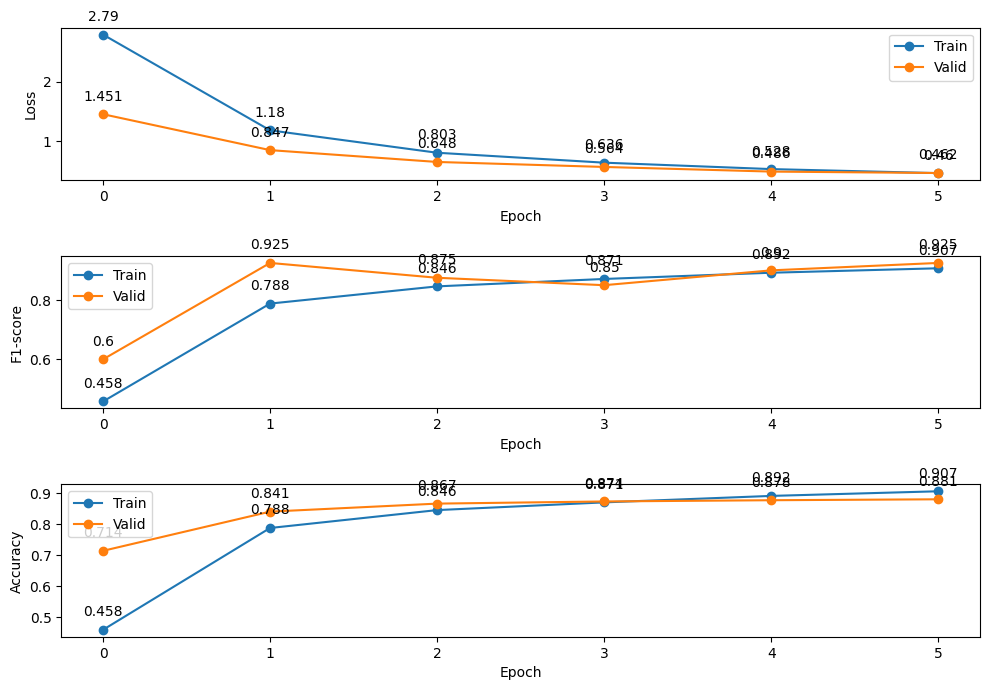

In [68]:
plots = plt.figure(figsize=(10, 7))

plt.subplot(3, 1, 1)
plt.plot(np.round(train_epoch_losses, 3), label='Train', marker='o')
plt.plot(np.round(valid_epoch_losses, 3), label='Valid', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

for i, txt in enumerate(np.round(train_epoch_losses, 3)):
    plt.annotate(txt, (i, train_epoch_losses[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(np.round(valid_epoch_losses, 3)):
    plt.annotate(txt, (i, valid_epoch_losses[i]), textcoords="offset points", xytext=(0,10), ha='center')


plt.subplot(3, 1, 2)
plt.plot(np.round(train_epoch_f1, 3), label='Train', marker='o')
plt.plot(np.round(valid_epoch_f1, 3), label='Valid', marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()

for i, txt in enumerate(np.round(train_epoch_f1, 3)):
    plt.annotate(txt, (i, train_epoch_f1[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(np.round(valid_epoch_f1, 3)):
    plt.annotate(txt, (i, valid_epoch_f1[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.subplot(3, 1, 3)
plt.plot(np.round(train_epoch_acc, 3), label='Train', marker='o')
plt.plot(np.round(valid_epoch_acc, 3), label='Valid', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

for i, txt in enumerate(np.round(train_epoch_acc, 3)):
    plt.annotate(txt, (i, train_epoch_acc[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(np.round(valid_epoch_acc, 3)):
    plt.annotate(txt, (i, valid_epoch_acc[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

In [46]:
!wget -o image3.jpeg https://gas-kvas.com/grafic/uploads/posts/2023-09/1695993532_gas-kvas-com-p-kartinki-plavanie-29.jpg

In [43]:
!wget -o image.jpeg https://gas-kvas.com/grafic/uploads/posts/2023-10/1696533420_gas-kvas-com-p-kartinki-voleibol-14.jpg

In [39]:
!wget -o image2.jpeg https://smartgambling.ru/storage/app/media/uploaded-files/125916.jpg

In [41]:
resize = T.Resize((244, 244))

In [49]:
!wget -o image101.jpg https://sportishka.com/uploads/posts/2022-11/1667484652_25-sportishka-com-p-tipi-plavaniya-krasivo-27.jpg

85


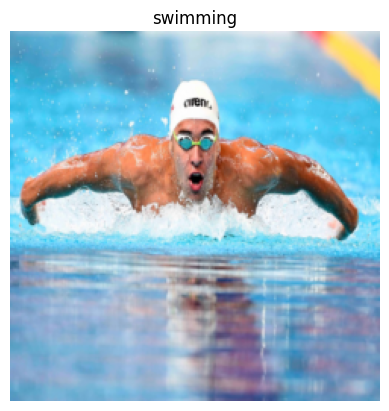

In [59]:
img322 = resize(io.read_image('/content/1667484652_25-sportishka-com-p-tipi-plavaniya-krasivo-27.jpg')/255)
model.to(DEVICE)
plt.imshow(torch.permute(img322, (1, 2, 0)))
with torch.inference_mode():
  pred_class = model(img322.unsqueeze(0).to(DEVICE)).argmax(dim=1).item()
(print(pred_class))
plt.axis('off')
plt.title(idx2class[pred_class]);